### We are normalizing from 0 to 1 without subtracting mean and dividing by std unlike other notebooks

In [106]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch.utils import data as D
import os

In [107]:
from PIL import Image

In [108]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
use_cuda=True

In [109]:
class Net(nn.Module):
    def __init__(self, features, num_classes, init_weights=True):
        super(Net, self).__init__()
        
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(4*4*50, 500),
            nn.ReLU(True),
            nn.Linear(500, num_classes)
        )
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        # x are the logits values
        return x 
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)



In [110]:
"""
torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
"""

def make_layers(cfg, in_channels, kernel_size, stride, padding, batch_norm=False):
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=kernel_size, padding=padding)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


"""
Refer VGG19_bn configurationh here: 
https://github.com/pytorch/vision/blob/76702a03d6cc2e4f431bfd1914d5e301c07bd489/torchvision/models/vgg.py#L63
"""
cfgs = {
    #'E': [64, 64, 'M',128, 128, 'M',256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',512, 512, 512, 512, 'M'],
    'E': [20, 'M', 50, 'M']
}

model_layers = make_layers(cfgs['E'],in_channels=1, kernel_size=5, stride=1, padding=0, batch_norm=False)

In [111]:
class CustomDS(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, path, train=True):
        """ Intialize the dataset
        """
        if train:
            data_path = os.path.join(path,'x_train.npy')
            targets_path = os.path.join(path,'y_train.npy')
        else:
            data_path = os.path.join(path,'x_test.npy')
            targets_path = os.path.join(path,'y_test.npy')

        self.path = data_path
        self.data = np.load(data_path)
        self.targets = np.load(targets_path)
        #self.transform = transforms.ToTensor()
        self.transform = transforms.Compose([
                       transforms.ToTensor()
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ])
        self.len = np.shape(self.data)[0]
        
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        data = self.data[index]
        image = Image.fromarray(data)
        
        target = int(self.targets[index])
        
        #data = (data * 255).astype(np.uint8)
        #data = data.reshape(28,28)
        #image = Image.fromarray((data * 255).astype(np.uint8))
        #image = Image.fromarray(data.astype(np.uint8))
        
        return self.transform(image), target

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [112]:
directory = './data/fmnist'

IS_DATA_READY = True
assert(IS_DATA_READY == True)

x_train = np.load(directory + '/x_train.npy')
y_train = np.load(directory + '/y_train.npy')
x_test = np.load(directory + '/x_test.npy')
y_test = np.load(directory + '/y_test.npy')
print('x_train shape : {}'.format(x_train.shape))
print('y_train shape : {}'.format(y_train.shape))
print('x_test shape : {}'.format(x_test.shape))
print('y_test shape : {}'.format(y_test.shape))


# Simple dataset. Only save path to image and load it and transform to tensor when call __getitem__.
filepath = './data/fmnist/'
train_set = CustomDS(filepath, train=True)
test_set = CustomDS(filepath, train=False)

# total images in set
print(train_set.len)
print(test_set.len)

x_train shape : (60000, 28, 28)
y_train shape : (60000,)
x_test shape : (10000, 28, 28)
y_test shape : (10000,)
60000
10000


In [113]:
# main method
## Training settings
# input batch size for training (default: 64)
BATCH_SIZE = 1

# input batch size for testing (default: 1000)
TEST_BATCH_SIZE = 1

# number of epochs to train
EPOCHS = 10

#learning rate (default: 0.01)
LR = 0.01

#SGD momentum (default: 0.5)
MOMENTUM = 0.5

# how many batches to wait before logging training status
LOG_INTERVAL = 10

SAVE_MODEL = True
SEED = 1
NO_CUDA = False
USE_CUDA = not NO_CUDA and torch.cuda.is_available()

NUM_CLASSES=10

torch.manual_seed(SEED)

device = torch.device("cuda" if USE_CUDA else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}


In [114]:
# FMNIST Test dataset and dataloader declaration
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('./data/', train=False, download=True, 
#                    transform=transforms.Compose([transforms.ToTensor(),])),
#                    batch_size=1, shuffle=True)

train_loader = D.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, **kwargs)
test_loader = D.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, **kwargs)


# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# # Initialize the network
# model = Net().to(device)

# # Load the pretrained model
# model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# # Set the model in evaluation mode. In this case this is for the Dropout layers
# model.eval()

pretrained_model = "model/fmnist/v2/fmnist_cnn.pt"
# Initialize the network
model = Net(model_layers, num_classes=NUM_CLASSES).cuda()

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()


CUDA Available:  True


Net(
  (features): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=800, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [115]:
import torch
import operator as op
import functools as ft


'''reduce_* helper functions reduce tensors on all dimensions but the first.
They are intended to be used on batched tensors where dim 0 is the batch dim.
'''


def reduce_sum(x, keepdim=True):
    # silly PyTorch, when will you get proper reducing sums/means?
    for a in reversed(range(1, x.dim())):
        x = x.sum(a, keepdim=keepdim)
    return x


def reduce_mean(x, keepdim=True):
    numel = ft.reduce(op.mul, x.size()[1:])
    x = reduce_sum(x, keepdim=keepdim)
    return x / numel


def reduce_min(x, keepdim=True):
    for a in reversed(range(1, x.dim())):
        x = x.min(a, keepdim=keepdim)[0]
    return x


def reduce_max(x, keepdim=True):
    for a in reversed(range(1, x.dim())):
        x = x.max(a, keepdim=keepdim)[0]
    return x


def torch_arctanh(x, eps=1e-6):
    x *= (1. - eps)
    return (torch.log((1 + x) / (1 - x))) * 0.5


def l2r_dist(x, y, keepdim=True, eps=1e-8):
    d = (x - y)**2
    d = reduce_sum(d, keepdim=keepdim)
    d += eps  # to prevent infinite gradient at 0
    return d.sqrt()


def l2_dist(x, y, keepdim=True):
    d = (x - y)**2
    return reduce_sum(d, keepdim=keepdim)


def l1_dist(x, y, keepdim=True):
    d = torch.abs(x - y)
    return reduce_sum(d, keepdim=keepdim)


def l2_norm(x, keepdim=True):
    norm = reduce_sum(x*x, keepdim=keepdim)
    return norm.sqrt()


def l1_norm(x, keepdim=True):
    return reduce_sum(x.abs(), keepdim=keepdim)


def rescale(x, x_min=-1., x_max=1.):
    return x * (x_max - x_min) + x_min


def tanh_rescale(x, x_min=-1., x_max=1.):
    return (torch.tanh(x) + 1) * 0.5 * (x_max - x_min) + x_min

In [121]:
"""PyTorch Carlini and Wagner L2 attack algorithm.

Based on paper by Carlini & Wagner, https://arxiv.org/abs/1608.04644 and a reference implementation at
https://github.com/tensorflow/cleverhans/blob/master/cleverhans/attacks_tf.py
"""
import os
import sys
import torch
import numpy as np
from torch import optim
from torch import autograd
#from .helpers import *


class AttackCarliniWagnerL2:

    def __init__(self, targeted=True, search_steps=None, max_steps=None, cuda=True, debug=False):
        self.debug = debug
        self.targeted = targeted
        #self.num_classes = 1000
        self.num_classes = 10
        self.confidence = 0  # FIXME need to find a good value for this, 0 value used in paper not doing much...
        self.initial_const = 0.1  # bumped up from default of .01 in reference code
        self.binary_search_steps = search_steps or 5
        self.repeat = self.binary_search_steps >= 10
        self.max_steps = max_steps or 1000
        self.abort_early = True
        self.clip_min = -1.
        self.clip_max = 1.
        self.cuda = cuda
        self.clamp_fn = 'tanh'  # set to something else perform a simple clamp instead of tanh
        self.init_rand = False  # an experiment, does a random starting point help?

    def _compare(self, output, target):
        if not isinstance(output, (float, int, np.int64)):
            output = np.copy(output)
            if self.targeted:
                output[target] -= self.confidence
            else:
                output[target] += self.confidence
            output = np.argmax(output)
        if self.targeted:
            return output == target
        else:
            return output != target

    def _loss(self, output, target, dist, scale_const):
        # compute the probability of the label class versus the maximum other
        
        # for the targeted attack, real will contain the current logit values for the targeted class
        # This basically tell us what is the current probability of the image being classified as the target class
        # multiplying by one hot encoded target ensures that other (index != target) logit values become 0
        # sum(1) simply gives us the logit value of the target class
        real = (target * output).sum(1)
        
        # indices other than target class will have their logit values, target index will have -10000
        # takes the maximum value when we suppress the logit of the targeted class
        # this will give the logit of the most likely other class
        # in the first run, this would most likely be the prob of the true class
        other = ((1. - target) * output - target * 10000.).max(1)[0]
        
        print('output: ', output)
        print('real: ', real)
        print('other: ', other)
        
        print('dist shape: ', dist.shape)
        print('dist: ', dist)
        
        if self.targeted:
            # if targeted, optimize for making the other class most likely
            loss1 = torch.clamp(other - real + self.confidence, min=0.)  # equiv to max(..., 0.)
        else:
            # if non-targeted, optimize for making this class least likely.
            loss1 = torch.clamp(real - other + self.confidence, min=0.)  # equiv to max(..., 0.)
        
        loss1 = torch.sum(scale_const * loss1)
        loss2 = dist.sum()
        
        print('loss2 which is dist.sum: ', loss2)

        loss = loss1 + loss2
        print('loss: ', loss)
        
        return loss

    def _optimize(self, optimizer, model, input_var, modifier_var, target_var, scale_const_var, input_orig=None):
        # apply modifier and clamp resulting image to keep bounded from clip_min to clip_max
        if self.clamp_fn == 'tanh':
            input_adv = tanh_rescale(modifier_var + input_var, self.clip_min, self.clip_max)
        else:
            input_adv = torch.clamp(modifier_var + input_var, self.clip_min, self.clip_max)
        
        print('input_adv type:{} shape:{} min:{} max:{}'.format(type(input_adv),input_adv.shape, torch.min(input_adv),torch.max(input_adv)))
        
        output = model(input_adv)

        # distance to the original input data
        if input_orig is None:
            dist = l2_dist(input_adv, input_var, keepdim=False)
        else:
            dist = l2_dist(input_adv, input_orig, keepdim=False)
            
            

        loss = self._loss(output, target_var, dist, scale_const_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #loss_np = loss.data[0] #throws error
        loss_np = loss.data
        dist_np = dist.data.cpu().numpy()
        output_np = output.data.cpu().numpy()
        input_adv_np = input_adv.data.permute(0, 2, 3, 1).cpu().numpy()  # back to BHWC for numpy consumption
        return loss_np, dist_np, output_np, input_adv_np

    def run(self, model, input, target, batch_idx=0):
        batch_size = input.size(0)
        print('batch size: ', batch_size)
        # set the lower and upper bounds accordingly
        lower_bound = np.zeros(batch_size)
        scale_const = np.ones(batch_size) * self.initial_const
        upper_bound = np.ones(batch_size) * 1e10

        # python/numpy placeholders for the overall best l2, label score, and adversarial image
        o_best_l2 = [1e10] * batch_size
        o_best_score = [-1] * batch_size
        o_best_attack = input.permute(0, 2, 3, 1).cpu().numpy()

        # setup input (image) variable, clamp/scale as necessary
        if self.clamp_fn == 'tanh':
            # convert to tanh-space, input already int -1 to 1 range, does it make sense to do
            # this as per the reference implementation or can we skip the arctanh?
            input_var = autograd.Variable(torch_arctanh(input), requires_grad=False)
            input_orig = tanh_rescale(input_var, self.clip_min, self.clip_max)
        else:
            input_var = autograd.Variable(input, requires_grad=False)
            input_orig = None

        # setup the target variable, we need it to be in one-hot form for the loss function
        target_onehot = torch.zeros(target.size() + (self.num_classes,))
        if self.cuda:
            target_onehot = target_onehot.cuda()
        target_onehot.scatter_(1, target.unsqueeze(1), 1.)
        
        #target_onehot will have a 1 at the index of the targeted class (in the case of targeted attack)
        print('target_onehot: ', target_onehot)
        
        target_var = autograd.Variable(target_onehot, requires_grad=False)

        # setup the modifier variable, this is the variable we are optimizing over
        modifier = torch.zeros(input_var.size()).float()
        if self.init_rand:
            # Experiment with a non-zero starting point...
            modifier = torch.normal(means=modifier, std=0.001)
        if self.cuda:
            modifier = modifier.cuda()
        modifier_var = autograd.Variable(modifier, requires_grad=True)

        optimizer = optim.Adam([modifier_var], lr=0.0005)

        for search_step in range(self.binary_search_steps):
            print('Batch: {0:>3}, search step: {1}'.format(batch_idx, search_step))
            if self.debug:
                print('Const:')
                for i, x in enumerate(scale_const):
                    print(i, x)
            best_l2 = [1e10] * batch_size
            best_score = [-1] * batch_size

            # The last iteration (if we run many steps) repeat the search once.
            if self.repeat and search_step == self.binary_search_steps - 1:
                scale_const = upper_bound

            scale_const_tensor = torch.from_numpy(scale_const).float()
            if self.cuda:
                scale_const_tensor = scale_const_tensor.cuda()
            scale_const_var = autograd.Variable(scale_const_tensor, requires_grad=False)

            prev_loss = 1e6
            for step in range(self.max_steps):
                # perform the attack
                loss, dist, output, adv_img = self._optimize(
                    optimizer,
                    model,
                    input_var,
                    modifier_var,
                    target_var,
                    scale_const_var,
                    input_orig)

                if step % 100 == 0 or step == self.max_steps - 1:
                    print('Step: {0:>4}, loss: {1:6.4f}, dist: {2:8.5f}, modifier mean: {3:.5e}'.format(
                        step, loss, dist.mean(), modifier_var.data.mean()))

                if self.abort_early and step % (self.max_steps // 10) == 0:
                    if loss > prev_loss * .9999:
                        print('Aborting early...')
                        break
                    prev_loss = loss

                # update best result found
                for i in range(batch_size):
                    target_label = target[i]
                    output_logits = output[i]
                    output_label = np.argmax(output_logits)
                    di = dist[i]
                    if self.debug:
                        if step % 100 == 0:
                            print('{0:>2} dist: {1:.5f}, output: {2:>3}, {3:5.3}, target {4:>3}'.format(
                                i, di, output_label, output_logits[output_label], target_label))
                    if di < best_l2[i] and self._compare(output_logits, target_label):
                        if self.debug:
                            print('{0:>2} best step,  prev dist: {1:.5f}, new dist: {2:.5f}'.format(
                                  i, best_l2[i], di))
                        best_l2[i] = di
                        best_score[i] = output_label
                    if di < o_best_l2[i] and self._compare(output_logits, target_label):
                        if self.debug:
                            print('{0:>2} best total, prev dist: {1:.5f}, new dist: {2:.5f}'.format(
                                  i, o_best_l2[i], di))
                        o_best_l2[i] = di
                        o_best_score[i] = output_label
                        o_best_attack[i] = adv_img[i]

                sys.stdout.flush()
                # end inner step loop

            # adjust the constants
            batch_failure = 0
            batch_success = 0
            for i in range(batch_size):
                if self._compare(best_score[i], target[i]) and best_score[i] != -1:
                    # successful, do binary search and divide const by two
                    upper_bound[i] = min(upper_bound[i], scale_const[i])
                    if upper_bound[i] < 1e9:
                        scale_const[i] = (lower_bound[i] + upper_bound[i]) / 2
                    if self.debug:
                        print('{0:>2} successful attack, lowering const to {1:.3f}'.format(
                            i, scale_const[i]))
                else:
                    # failure, multiply by 10 if no solution found
                    # or do binary search with the known upper bound
                    lower_bound[i] = max(lower_bound[i], scale_const[i])
                    if upper_bound[i] < 1e9:
                        scale_const[i] = (lower_bound[i] + upper_bound[i]) / 2
                    else:
                        scale_const[i] *= 10
                    if self.debug:
                        print('{0:>2} failed attack, raising const to {1:.3f}'.format(
                            i, scale_const[i]))
                if self._compare(o_best_score[i], target[i]) and o_best_score[i] != -1:
                    batch_success += 1
                else:
                    batch_failure += 1

            print('Num failures: {0:2d}, num successes: {1:2d}\n'.format(batch_failure, batch_success))
            sys.stdout.flush()
            # end outer search loop

        return o_best_attack


In [122]:
TARGETED = True
MAX_STEPS = 1000
SEARCH_STEPS = 6
NO_CUDA = False
DEBUG = False

attack = AttackCarliniWagnerL2(
        targeted=TARGETED,
        max_steps=MAX_STEPS,
        search_steps=SEARCH_STEPS,
        cuda=not NO_CUDA,
        debug=DEBUG)

In [123]:
#for batch_idx, (input, target) in enumerate(loader):
    
#     input = input.cuda()
#     target = target.cuda()

#     input_adv = attack.run(model, input, target, batch_idx)

#     start_index = args.batch_size * batch_idx
#     indices = list(range(start_index, start_index + input.size(0)))
#     for filename, o in zip(dataset.filenames(indices, basename=True), input_adv):
#         output_file = os.path.join(args.output_dir, filename)
#         imsave(output_file, (o + 1.0) * 0.5, format='png')

In [124]:
a,b = iter(test_loader).next()
a=a.cuda()
torch.min(a)

tensor(0., device='cuda:0')

In [125]:
loader = test_loader

iterations = 0
thresh_on_iterations = 3

success_record = []

for batch_idx, (input_tensor, input_label) in enumerate(loader):
    print('\n\n-------iteration: {}----------'.format(iterations))
    
    # clean image
    input_tensor = input_tensor.cuda()
    
    # original label for the clean image
    input_label = input_label.cuda()
    
    pred_input = model(input_tensor)
    pred_prob_input = F.softmax(pred_input, dim=1)
    print('prediction of clean sample: {} with probability: {}'
          .format(torch.argmax(pred_prob_input),torch.max(pred_prob_input)))
    
    # if the attack is targeted, we will target the next class modulo number of classes
    if TARGETED == True:
        target = (input_label+1)%10
    # else the target is kept as the original label as per attack design
    else:
        target = input_label
    
    # result obtained is a numpy array
    adversarial_img = attack.run(model, input_tensor, target, batch_idx)
    
    # reshape
    adversarial_img = np.transpose(adversarial_img, (0,3,1,2))
    
    # conver to torch tensor
    adversarial_tensor = torch.from_numpy(adversarial_img).cuda()
    
    # obtain the prediction by the model
    pred_adv = model(adversarial_tensor)
    pred_prob_adv = F.softmax(pred_adv, dim=1)
    print('prediction of adversarial sample: {} with probability: {}'.
      format(torch.argmax(pred_prob_adv),torch.max(pred_prob_adv)))

    
    clean_label = input_label.item()
    #pred_adv_label = torch.max(pred_adv, 1)[1].item()
    pred_adv_label = torch.argmax(pred_prob_adv)
    
    print('Original label of the clean image is: {} and predicted label of the adversarial image is {}'\
          .format(clean_label,pred_adv_label))
    
    result = 0
    if TARGETED:
        if pred_adv_label == target.item():
            result = 1
    else:
        if pred_adv_label != clean_label:
            result = 1
    
    success_record.append(result)
    
    iterations += 1
    if iterations == thresh_on_iterations:
        break



-------iteration: 0----------
prediction of clean sample: 9 with probability: 0.7324443459510803
batch size:  1
target_onehot:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
Batch:   0, search step: 0
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:0.0 max:0.9999990463256836
output:  tensor([[-1.7841, -8.7009, -1.9428, -3.9684, -5.9410,  4.7206, -2.2188,  7.4333,
          3.7168,  8.5274]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.7841], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([8.5274], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(1.0312, device='cuda:0', grad_fn=<AddBackward0>)
Step:    0, loss: 1.0312, dist:  0.00000, modifier mean: -1.12588e-04
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.0

input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.006449401378631592 max:0.9999990463256836
output:  tensor([[-1.6844, -8.6678, -1.8097, -3.9174, -5.7621,  4.5118, -2.0725,  7.3942,
          3.8463,  7.9823]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.6844], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([7.9823], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0124], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0124, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.9791, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.006924748420715332 max:0.9999990463256836
output:  tensor([[-1.6760, -8.6649, -1.7995, -3.9141, -5.7496,  4.4950, -2.0599,  7.3887,
          3.8564,  7.9429]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.6760], device='cuda:0', grad_fn=<SumBackward1>)
o

input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.012554287910461426 max:0.9999990463256836
output:  tensor([[-1.5804, -8.6468, -1.6803, -3.8952, -5.6078,  4.3432, -1.9159,  7.3061,
          3.9773,  7.4981]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5804], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([7.4981], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0355], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0355, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.9433, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.013022124767303467 max:0.9999990463256836
output:  tensor([[-1.5733, -8.6477, -1.6710, -3.8952, -5.5958,  4.3366, -1.9050,  7.2976,
          3.9875,  7.4629]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5733], device='cuda:0', grad_fn=<SumBackward1>)
o

loss:  tensor(0.9209, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.017840266227722168 max:0.9999990463256836
output:  tensor([[-1.5042, -8.6559, -1.5772, -3.9370, -5.4499,  4.3183, -1.8044,  7.1264,
          4.1087,  7.1557]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5042], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([7.1557], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0539], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0539, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.9199, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.018136560916900635 max:0.9999990463256836
output:  tensor([[-1.4998, -8.6554, -1.5707, -3.9439, -5.4386,  4.3231, -1.7979,  7.1038,
          4.1166,  7.1430]], device='cuda:0', grad_fn=<AddmmBackward>)
real

input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02183777093887329 max:0.9999990463256836
output:  tensor([[-1.4521, -8.6616, -1.5008, -3.9986, -5.3253,  4.3448, -1.7190,  6.9380,
          4.2080,  6.9361]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.4521], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.9380], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0655], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0655, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.9045, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.021980702877044678 max:0.9999990463256836
output:  tensor([[-1.4493, -8.6605, -1.4965, -4.0064, -5.3169,  4.3515, -1.7143,  6.9157,
          4.2135,  6.9323]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.4493], device='cuda:0', grad_fn=<SumBackward1>)
ot

input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02437049150466919 max:0.9999990463256836
output:  tensor([[-1.4151, -8.6672, -1.4437, -4.0486, -5.2253,  4.3643, -1.6527,  6.7898,
          4.2874,  6.7714]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.4151], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.7898], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0749], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0749, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8954, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02444899082183838 max:0.9999990463256836
output:  tensor([[-1.4129, -8.6665, -1.4401, -4.0537, -5.2186,  4.3673, -1.6490,  6.7746,
          4.2926,  6.7665]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.4129], device='cuda:0', grad_fn=<SumBackward1>)
oth

input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02549278736114502 max:0.9999990463256836
output:  tensor([[-1.3801, -8.6575, -1.3981, -4.0958, -5.1487,  4.3663, -1.5990,  6.6545,
          4.3557,  6.6579]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.3801], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.6579], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0836], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0836, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8874, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.025511324405670166 max:0.9999990463256836
output:  tensor([[-1.3779, -8.6566, -1.3953, -4.1002, -5.1433,  4.3681, -1.5959,  6.6431,
          4.3606,  6.6526]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.3779], device='cuda:0', grad_fn=<SumBackward1>)
ot

dist:  tensor([0.0911], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0911, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8835, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.025848031044006348 max:0.9999990463256836
output:  tensor([[-1.3561, -8.6520, -1.3678, -4.1347, -5.0846,  4.3765, -1.5568,  6.5512,
          4.4134,  6.5623]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.3561], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.5623], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0915], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0915, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8834, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.025864601135253906 max:0.9999990463256836
output:  tensor([[

output:  tensor([[-1.3381, -8.6457, -1.3441, -4.1605, -5.0368,  4.3728, -1.5251,  6.4842,
          4.4550,  6.4868]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.3381], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.4868], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0978], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0978, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8803, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.026145458221435547 max:0.9999990463256836
output:  tensor([[-1.3368, -8.6452, -1.3421, -4.1622, -5.0330,  4.3720, -1.5226,  6.4799,
          4.4582,  6.4802]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.3368], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.4802], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0983], de

loss2 which is dist.sum:  tensor(0.1032, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8782, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02637350559234619 max:0.9999990463256836
output:  tensor([[-1.3234, -8.6374, -1.3221, -4.1848, -4.9926,  4.3696, -1.4967,  6.4235,
          4.4919,  6.4182]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.3234], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.4235], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1037], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1037, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8784, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02637481689453125 max:0.9999990463256836
output:  tensor([[-1.3225, -8.6371, -1.3207, -4.1870, -4.9896,  4.3705, -1.4950,  6.4

input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02637338638305664 max:0.9999990463256836
output:  tensor([[-1.3126, -8.6337, -1.3060, -4.2082, -4.9587,  4.3776, -1.4754,  6.3636,
          4.5210,  6.3766]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.3126], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.3766], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1083], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1083, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8772, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.026446104049682617 max:0.9999990463256836
output:  tensor([[-1.3114, -8.6339, -1.3047, -4.2078, -4.9563,  4.3752, -1.4730,  6.3644,
          4.5234,  6.3679]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.3114], device='cuda:0', grad_fn=<SumBackward1>)
ot

input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.026587724685668945 max:0.9999990463256836
output:  tensor([[-1.3027, -8.6329, -1.2929, -4.2185, -4.9328,  4.3732, -1.4541,  6.3340,
          4.5437,  6.3243]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.3027], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.3340], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1128], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1128, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8765, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02663266658782959 max:0.9999990463256836
output:  tensor([[-1.3018, -8.6331, -1.2918, -4.2186, -4.9309,  4.3718, -1.4523,  6.3338,
          4.5455,  6.3182]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.3018], device='cuda:0', grad_fn=<SumBackward1>)
ot

loss2 which is dist.sum:  tensor(0.1158, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8756, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02650374174118042 max:0.9999990463256836
output:  tensor([[-1.2961, -8.6315, -1.2825, -4.2333, -4.9107,  4.3786, -1.4410,  6.2947,
          4.5621,  6.2996]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2961], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.2996], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1158], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1158, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8754, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02646845579147339 max:0.9999990463256836
output:  tensor([[-1.2958, -8.6312, -1.2819, -4.2351, -4.9093,  4.3802, -1.4405,  6.2

dist:  tensor([0.1183], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1183, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8748, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.026524841785430908 max:0.9999990463256836
output:  tensor([[-1.2909, -8.6318, -1.2742, -4.2425, -4.8930,  4.3814, -1.4294,  6.2708,
          4.5767,  6.2715]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2909], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.2715], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1185], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1185, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8748, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.026552855968475342 max:0.9999990463256836
output:  tensor([[

dist:  tensor([0.1212], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1212, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8746, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02641195058822632 max:0.9999990463256836
output:  tensor([[-1.2812, -8.6389, -1.2638, -4.2551, -4.8784,  4.3869, -1.4226,  6.2500,
          4.5924,  6.2474]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2812], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.2500], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1214], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1214, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8745, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.026341557502746582 max:0.9999990463256836
output:  tensor([[-

real:  tensor([-1.2743], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.2354], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1233], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1233, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8743, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.026198744773864746 max:0.9999990463256836
output:  tensor([[-1.2734, -8.6459, -1.2544, -4.2672, -4.8640,  4.3890, -1.4168,  6.2317,
          4.6079,  6.2285]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2734], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.2317], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1237], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1237, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8742, device='cuda:0', g

input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02588474750518799 max:0.9999990463256836
output:  tensor([[-1.2713, -8.6484, -1.2495, -4.2769, -4.8555,  4.3963, -1.4146,  6.2121,
          4.6154,  6.2277]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2713], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.2277], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1245], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1245, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8744, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02586674690246582 max:0.9999990463256836
output:  tensor([[-1.2712, -8.6485, -1.2492, -4.2774, -4.8548,  4.3967, -1.4143,  6.2107,
          4.6160,  6.2271]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2712], device='cuda:0', grad_fn=<SumBackward1>)
oth

dist:  tensor([0.1262], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1262, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8741, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.025946080684661865 max:0.9999990463256836
output:  tensor([[-1.2678, -8.6502, -1.2447, -4.2773, -4.8467,  4.3915, -1.4084,  6.2110,
          4.6241,  6.2023]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2678], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.2110], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1264], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1264, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8743, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02590322494506836 max:0.9999990463256836
output:  tensor([[-

input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.025718867778778076 max:0.9999990463256836
output:  tensor([[-1.2665, -8.6504, -1.2420, -4.2832, -4.8412,  4.3970, -1.4068,  6.1957,
          4.6284,  6.2029]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2665], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.2029], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1270], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1270, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8739, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.025767982006072998 max:0.9999990463256836
output:  tensor([[-1.2660, -8.6508, -1.2416, -4.2822, -4.8405,  4.3951, -1.4057,  6.1980,
          4.6291,  6.1983]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2660], device='cuda:0', grad_fn=<SumBackward1>)
o

input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.025665998458862305 max:0.9999990463256836
output:  tensor([[-1.2649, -8.6513, -1.2396, -4.2856, -4.8361,  4.3971, -1.4042,  6.1895,
          4.6332,  6.1955]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2649], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.1955], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1277], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1277, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8738, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.025709688663482666 max:0.9999990463256836
output:  tensor([[-1.2646, -8.6516, -1.2393, -4.2847, -4.8356,  4.3955, -1.4034,  6.1915,
          4.6338,  6.1917]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2646], device='cuda:0', grad_fn=<SumBackward1>)
o

input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.025633156299591064 max:0.9999990463256836
output:  tensor([[-1.2637, -8.6511, -1.2379, -4.2876, -4.8331,  4.3977, -1.4021,  6.1844,
          4.6357,  6.1910]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2637], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.1910], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1283], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1283, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8738, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.025587499141693115 max:0.9999990463256836
output:  tensor([[-1.2638, -8.6509, -1.2379, -4.2888, -4.8330,  4.3993, -1.4027,  6.1818,
          4.6357,  6.1938]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2638], device='cuda:0', grad_fn=<SumBackward1>)
o

loss2 which is dist.sum:  tensor(0.1291, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8735, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.025782525539398193 max:0.9999990463256836
output:  tensor([[-1.2638, -8.6519, -1.2385, -4.2881, -4.8294,  4.4069, -1.3976,  6.1793,
          4.6370,  6.1785]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2638], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.1793], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1292], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1292, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8735, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.025741219520568848 max:0.9999990463256836
output:  tensor([[-1.2642, -8.6518, -1.2388, -4.2895, -4.8291,  4.4095, -1.3979,  6

real:  tensor([-1.2627], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.1729], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1302], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1302, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8737, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.025916993618011475 max:0.9999990463256836
output:  tensor([[-1.2630, -8.6503, -1.2390, -4.2919, -4.8271,  4.4177, -1.3961,  6.1680,
          4.6389,  6.1748]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2630], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.1748], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1299], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1299, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8737, device='cuda:0', g

real:  tensor([-1.2621], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.1653], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1307], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1307, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8734, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.026210427284240723 max:0.9999990463256836
output:  tensor([[-1.2616, -8.6514, -1.2375, -4.2911, -4.8228,  4.4176, -1.3916,  6.1689,
          4.6424,  6.1583]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2616], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.1689], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1310], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1310, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8741, device='cuda:0', g

loss:  tensor(0.8734, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02623957395553589 max:0.9999990463256836
output:  tensor([[-1.2612, -8.6513, -1.2373, -4.2937, -4.8205,  4.4225, -1.3910,  6.1618,
          4.6450,  6.1567]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2612], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.1618], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1314], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1314, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8737, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.026235580444335938 max:0.9999990463256836
output:  tensor([[-1.2612, -8.6511, -1.2373, -4.2938, -4.8207,  4.4229, -1.3910,  6.1612,
          4.6449,  6.1571]], device='cuda:0', grad_fn=<AddmmBackward>)
real:

input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02624034881591797 max:0.9999990463256836
output:  tensor([[-1.2607, -8.6504, -1.2367, -4.2955, -4.8182,  4.4230, -1.3898,  6.1577,
          4.6460,  6.1555]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2607], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.1577], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1317], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1317, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8735, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.026143789291381836 max:0.9999990463256836
output:  tensor([[-1.2611, -8.6498, -1.2369, -4.2973, -4.8188,  4.4253, -1.3911,  6.1533,
          4.6455,  6.1623]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2611], device='cuda:0', grad_fn=<SumBackward1>)
ot

input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02620697021484375 max:0.9999990463256836
output:  tensor([[-1.2606, -8.6501, -1.2365, -4.2966, -4.8179,  4.4249, -1.3896,  6.1545,
          4.6461,  6.1568]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2606], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.1568], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1317], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1317, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8734, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.026301324367523193 max:0.9999990463256836
output:  tensor([[-1.2601, -8.6506, -1.2362, -4.2949, -4.8172,  4.4226, -1.3882,  6.1585,
          4.6468,  6.1500]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2601], device='cuda:0', grad_fn=<SumBackward1>)
ot

loss2 which is dist.sum:  tensor(0.1319, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8734, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02627462148666382 max:0.9999990463256836
output:  tensor([[-1.2597, -8.6504, -1.2358, -4.2960, -4.8167,  4.4231, -1.3887,  6.1559,
          4.6480,  6.1512]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2597], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.1559], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1321], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1321, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8736, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.0262678861618042 max:0.9999990463256836
output:  tensor([[-1.2597, -8.6505, -1.2357, -4.2962, -4.8168,  4.4233, -1.3887,  6.15

other:  tensor([6.1564], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1323], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1323, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8738, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02625483274459839 max:0.9999990463256836
output:  tensor([[-1.2595, -8.6493, -1.2358, -4.2964, -4.8165,  4.4228, -1.3883,  6.1544,
          4.6478,  6.1515]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2595], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.1544], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1321], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1321, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8735, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:

real:  tensor([-1.2602], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.1586], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1318], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1318, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8737, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.026210367679595947 max:0.9999990463256836
output:  tensor([[-1.2599, -8.6498, -1.2358, -4.2972, -4.8165,  4.4249, -1.3890,  6.1525,
          4.6479,  6.1538]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2599], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.1538], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1320], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1320, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8734, device='cuda:0', g

loss2 which is dist.sum:  tensor(0.1321, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8734, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02627432346343994 max:0.9999990463256836
output:  tensor([[-1.2594, -8.6499, -1.2352, -4.2965, -4.8155,  4.4233, -1.3882,  6.1545,
          4.6486,  6.1491]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2594], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.1545], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1323], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1323, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8737, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.02626734972000122 max:0.9999990463256836
output:  tensor([[-1.2594, -8.6497, -1.2353, -4.2966, -4.8156,  4.4235, -1.3883,  6.1

dist:  tensor([0.1324], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1324, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8739, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.026253819465637207 max:0.9999990463256836
output:  tensor([[-1.2596, -8.6493, -1.2353, -4.2968, -4.8155,  4.4240, -1.3885,  6.1534,
          4.6482,  6.1503]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2596], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([6.1534], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1322], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1322, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.8735, device='cuda:0', grad_fn=<AddBackward0>)
Step:  400, loss: 0.8735, dist:  0.13222, modifier mean: 5.70704e-04
Aborting early...
Num failures:  1, num successes:  0

Batch:   0, se

input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.040767133235931396 max:0.9999990463256836
output:  tensor([[-0.9041, -8.5637, -0.8464, -4.4481, -4.3368,  4.4805, -0.8914,  5.0773,
          5.0345,  5.0931]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9041], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([5.0931], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3460], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3460, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(6.3432, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.04245197772979736 max:0.9999990463256836
output:  tensor([[-0.8627, -8.5554, -0.8052, -4.4651, -4.2849,  4.4912, -0.8367,  4.9590,
          5.0799,  4.9705]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.8627], device='cuda:0', grad_fn=<SumBackward1>)
ot

input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.0510062575340271 max:0.9999990463256836
output:  tensor([[-0.6341, -8.3427, -0.6524, -4.2962, -4.3138,  4.4222, -0.5629,  4.5730,
          4.8324,  4.6537]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.6341], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.8324], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.5502], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.5502, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(6.0166, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.05112224817276001 max:0.9999990463256836
output:  tensor([[-0.6303, -8.3211, -0.6577, -4.2688, -4.3469,  4.4131, -0.5623,  4.5893,
          4.7813,  4.6840]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.6303], device='cuda:0', grad_fn=<SumBackward1>)
othe

loss2 which is dist.sum:  tensor(0.6971, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.7893, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.0630003809928894 max:0.9999990463256836
output:  tensor([[-0.4682, -8.2066, -0.5303, -4.0580, -4.3661,  4.2618, -0.3872,  4.5028,
          4.5990,  4.3197]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.4682], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.5990], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.7089], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.7089, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.7761, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.06388884782791138 max:0.9999990463256836
output:  tensor([[-0.4585, -8.1952, -0.5237, -4.0434, -4.3711,  4.2523, -0.3803,  4.49

other:  tensor([4.3923], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.8235], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.8235, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.5822, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.07084459066390991 max:0.9999990463256836
output:  tensor([[-0.3627, -8.0492, -0.4959, -3.9466, -4.4606,  4.2432, -0.3322,  4.3639,
          4.3668,  4.3515]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3627], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.3668], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.8306], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.8306, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.5601, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:

output:  tensor([[-0.2549, -7.9722, -0.4316, -3.8714, -4.4675,  4.1895, -0.2481,  4.2412,
          4.2429,  4.2541]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.2549], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.2541], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.9481], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.9481, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.4571, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.07621407508850098 max:0.9999990463256836
output:  tensor([[-0.2469, -7.9670, -0.4255, -3.8621, -4.4681,  4.1790, -0.2415,  4.2407,
          4.2325,  4.2409]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.2469], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.2409], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.9572], dev

loss:  tensor(5.3757, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.07963705062866211 max:0.9999990463256836
output:  tensor([[-0.1458, -7.9151, -0.3597, -3.8003, -4.4503,  4.1121, -0.1467,  4.1309,
          4.1497,  4.1065]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.1458], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1497], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.0700], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.0700, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.3655, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.07987451553344727 max:0.9999990463256836
output:  tensor([[-0.1421, -7.9083, -0.3612, -3.7953, -4.4571,  4.1113, -0.1456,  4.1285,
          4.1347,  4.1173]], device='cuda:0', grad_fn=<AddmmBackward>)
real: 

dist:  tensor([1.1552], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1552, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.3117, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08347803354263306 max:0.9999990463256836
output:  tensor([[-0.0688, -7.8469, -0.3072, -3.7378, -4.4495,  3.9776, -0.0796,  4.0705,
          4.0578,  4.0701]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.0688], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0705], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1614], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1614, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.3006, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08369547128677368 max:0.9999990463256836
output:  tensor([[-0

other:  tensor([4.0038], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2433], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2433, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.2523, device='cuda:0', grad_fn=<AddBackward0>)
Step:  100, loss: 5.2523, dist:  1.24328, modifier mean: 5.65385e-04
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08492076396942139 max:0.9999990463256836
output:  tensor([[-1.0397e-03, -7.8004e+00, -2.6046e-01, -3.6986e+00, -4.4145e+00,
          3.9461e+00,  2.4212e-03,  3.9618e+00,  3.9987e+00,  3.9525e+00]],
       device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.0010], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.9987], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2498], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2498, device='cuda:0', grad_fn=<SumBac

loss2 which is dist.sum:  tensor(1.3147, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.2189, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08651185035705566 max:0.9999990463256836
output:  tensor([[ 0.0516, -7.7536, -0.2287, -3.6531, -4.4057,  3.8749,  0.0599,  3.9108,
          3.9463,  3.8856]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.0516], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.9463], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.3191], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.3191, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.2138, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.0867617130279541 max:0.9999990463256836
output:  tensor([[ 0.0535, -7.7481, -0.2281, -3.6466, -4.4098,  3.8642,  0.0613,  3.915

other:  tensor([3.8872], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.3789], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.3789, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.1789, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08666902780532837 max:0.9999990463256836
output:  tensor([[ 0.0891, -7.7085, -0.2124, -3.6226, -4.4044,  3.8483,  0.1133,  3.8404,
          3.8796,  3.8692]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.0891], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.8796], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.3834], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.3834, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.1738, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:t

real:  tensor([0.1344], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.8443], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.4479], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.4479, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.1578, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08603626489639282 max:0.9999990463256836
output:  tensor([[ 0.1352, -7.6927, -0.1746, -3.5718, -4.3731,  3.8247,  0.1867,  3.8132,
          3.8358,  3.7037]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1352], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.8358], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.4517], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.4517, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.1522, device='cuda:0', grad

loss:  tensor(5.1208, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08739757537841797 max:0.9999990463256836
output:  tensor([[ 0.1648, -7.6554, -0.1722, -3.5625, -4.3878,  3.7771,  0.2151,  3.7750,
          3.7889,  3.7522]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1648], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.7889], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.4952], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.4952, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.1193, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08732253313064575 max:0.9999990463256836
output:  tensor([[ 0.1657, -7.6524, -0.1750, -3.5638, -4.3912,  3.7814,  0.2154,  3.7705,
          3.7837,  3.7616]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  

loss:  tensor(5.1015, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08812958002090454 max:0.9999990463256836
output:  tensor([[ 0.1992, -7.6276, -0.1552, -3.5447, -4.3991,  3.6943,  0.2471,  3.7698,
          3.7643,  3.7516]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1992], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.7698], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.5326], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.5326, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.1032, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08799779415130615 max:0.9999990463256836
output:  tensor([[ 0.2018, -7.6265, -0.1549, -3.5468, -4.3981,  3.6974,  0.2505,  3.7606,
          3.7633,  3.7529]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  

dist:  tensor([1.5754], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.5754, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.0845, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08667141199111938 max:0.9999990463256836
output:  tensor([[ 0.2231, -7.6132, -0.1519, -3.5407, -4.3961,  3.7323,  0.2863,  3.7045,
          3.7250,  3.7329]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2231], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.7329], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.5785], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.5785, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.0883, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.0866207480430603 max:0.9999990463256836
output:  tensor([[ 0.2

dist:  tensor([1.6205], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6205, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.0657, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08765363693237305 max:0.9999990463256836
output:  tensor([[ 0.2577, -7.5981, -0.1157, -3.5015, -4.3876,  3.6493,  0.3359,  3.6933,
          3.6967,  3.6725]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2577], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.6967], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6245], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6245, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.0636, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08757150173187256 max:0.9999990463256836
output:  tensor([[ 0.

output:  tensor([[ 0.2825, -7.5777, -0.0967, -3.4754, -4.3884,  3.6303,  0.3781,  3.6619,
          3.6529,  3.6355]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2825], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.6619], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6725], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.6725, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.0519, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.0875055193901062 max:0.9999990463256836
output:  tensor([[ 0.2875, -7.5775, -0.0915, -3.4756, -4.3829,  3.6232,  0.3857,  3.6508,
          3.6559,  3.6276]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2875], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.6559], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.6772], device

loss:  tensor(5.0392, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08761042356491089 max:0.9999990463256836
output:  tensor([[ 0.3142, -7.5629, -0.0635, -3.4655, -4.3635,  3.6126,  0.4392,  3.5783,
          3.6239,  3.5924]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3142], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.6239], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.7285], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.7285, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.0382, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08767008781433105 max:0.9999990463256836
output:  tensor([[ 0.3155, -7.5611, -0.0619, -3.4625, -4.3636,  3.6123,  0.4422,  3.5779,
          3.6186,  3.5877]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  

loss2 which is dist.sum:  tensor(1.7680, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.0208, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08800804615020752 max:0.9999990463256836
output:  tensor([[ 0.3343, -7.5390, -0.0379, -3.4327, -4.3656,  3.5407,  0.4753,  3.5798,
          3.5756,  3.5753]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3343], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.5798], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.7716], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.7716, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.0171, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08788037300109863 max:0.9999990463256836
output:  tensor([[ 0.3375, -7.5394, -0.0356, -3.4354, -4.3614,  3.5443,  0.4814,  3.56

dist:  tensor([1.8129], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.8129, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.0124, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08841264247894287 max:0.9999990463256836
output:  tensor([[ 0.3595, -7.5273, -0.0105, -3.4126, -4.3508,  3.5098,  0.5213,  3.5461,
          3.5476,  3.5217]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3595], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.5476], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.8166], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.8166, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.0047, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08847558498382568 max:0.9999990463256836
output:  tensor([[ 0.

loss2 which is dist.sum:  tensor(1.8495, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9987, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08898138999938965 max:0.9999990463256836
output:  tensor([[ 3.7629e-01, -7.5203e+00,  5.2522e-03, -3.4023e+00, -4.3374e+00,
          3.5093e+00,  5.6014e-01,  3.5043e+00,  3.5221e+00,  3.4869e+00]],
       device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3763], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.5221], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.8528], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.8528, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9986, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.0890302062034607 max:0.9999990463256836
output:  tensor([[ 3.7696e-01, -7.5194e+

output:  tensor([[ 0.3886, -7.5098,  0.0166, -3.3879, -4.3338,  3.4766,  0.5839,  3.4968,
          3.4990,  3.4744]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3886], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4990], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.8783], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.8783, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9887, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08901500701904297 max:0.9999990463256836
output:  tensor([[ 0.3862, -7.5067,  0.0131, -3.3861, -4.3396,  3.4799,  0.5808,  3.5032,
          3.4905,  3.4832]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3862], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.5032], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.8793], devic

loss2 which is dist.sum:  tensor(1.8983, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9878, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08933693170547485 max:0.9999990463256836
output:  tensor([[ 0.4053, -7.5033,  0.0316, -3.3790, -4.3259,  3.4371,  0.6119,  3.4838,
          3.4924,  3.4504]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4053], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4924], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.9001], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.9001, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9873, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08934271335601807 max:0.9999990463256836
output:  tensor([[ 0.4054, -7.5025,  0.0316, -3.3775, -4.3271,  3.4378,  0.6123,  3.48

other:  tensor([3.4670], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.9186], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.9186, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9772, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08942592144012451 max:0.999998927116394
output:  tensor([[ 0.4113, -7.4953,  0.0304, -3.3788, -4.3250,  3.4506,  0.6272,  3.4577,
          3.4701,  3.4574]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4113], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4701], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.9207], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.9207, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9795, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:to

output:  tensor([[ 0.4257, -7.4973,  0.0523, -3.3555, -4.3100,  3.4251,  0.6534,  3.4678,
          3.4632,  3.3765]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4257], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4678], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.9407], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.9407, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9829, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09034967422485352 max:0.999998927116394
output:  tensor([[ 0.4291, -7.4992,  0.0556, -3.3567, -4.3038,  3.4280,  0.6589,  3.4571,
          3.4671,  3.3649]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4291], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4671], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.9437], device

loss:  tensor(4.9794, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09054374694824219 max:0.999998927116394
output:  tensor([[ 0.4379, -7.4952,  0.0603, -3.3541, -4.2969,  3.4234,  0.6680,  3.4374,
          3.4569,  3.3640]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4379], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4569], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.9598], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.9598, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9788, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09048902988433838 max:0.999998927116394
output:  tensor([[ 0.4374, -7.4941,  0.0591, -3.3541, -4.2991,  3.4238,  0.6670,  3.4387,
          3.4539,  3.3694]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  te

dist:  tensor([1.9685], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.9685, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9748, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08989793062210083 max:0.999998927116394
output:  tensor([[ 0.4357, -7.4815,  0.0527, -3.3544, -4.3139,  3.4079,  0.6678,  3.4406,
          3.4320,  3.4181]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4357], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4406], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.9692], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.9692, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9741, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08994019031524658 max:0.999998927116394
output:  tensor([[ 0.43

dist:  tensor([1.9828], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.9828, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9648, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09013617038726807 max:0.999998927116394
output:  tensor([[ 0.4455, -7.4791,  0.0602, -3.3533, -4.3050,  3.4076,  0.6849,  3.4199,
          3.4282,  3.3963]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4455], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4282], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.9840], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.9840, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9667, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09017032384872437 max:0.999998927116394
output:  tensor([[ 0.44

real:  tensor([0.4463], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4201], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.9933], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.9933, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9671, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08994901180267334 max:0.999998927116394
output:  tensor([[ 0.4475, -7.4715,  0.0563, -3.3551, -4.3119,  3.4155,  0.6891,  3.4128,
          3.4129,  3.4111]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4475], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4155], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.9948], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.9948, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9628, device='cuda:0', grad_

output:  tensor([[ 0.4613, -7.4706,  0.0729, -3.3463, -4.3034,  3.3795,  0.7045,  3.4142,
          3.4201,  3.3736]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4613], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4201], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.0053], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.0053, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9641, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09027999639511108 max:0.999998927116394
output:  tensor([[ 0.4605, -7.4697,  0.0709, -3.3472, -4.3051,  3.3850,  0.7035,  3.4130,
          3.4173,  3.3779]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4605], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4173], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.0061], device

input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09008967876434326 max:0.999998927116394
output:  tensor([[ 0.4632, -7.4648,  0.0704, -3.3508, -4.3047,  3.3820,  0.7102,  3.3979,
          3.4097,  3.3943]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4632], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4097], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.0150], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.0150, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9615, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09020686149597168 max:0.999998927116394
output:  tensor([[ 0.4657, -7.4662,  0.0737, -3.3503, -4.3005,  3.3798,  0.7140,  3.3943,
          3.4128,  3.3841]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4657], device='cuda:0', grad_fn=<SumBackward1>)
other: 

dist:  tensor([2.0245], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.0245, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9603, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09027493000030518 max:0.999998927116394
output:  tensor([[ 0.4689, -7.4636,  0.0742, -3.3466, -4.3009,  3.3823,  0.7190,  3.3954,
          3.4035,  3.3749]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4689], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4035], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.0244], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.0244, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9590, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.090187668800354 max:0.999998927116394
output:  tensor([[ 0.4681

loss2 which is dist.sum:  tensor(2.0337, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9594, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09039413928985596 max:0.999998927116394
output:  tensor([[ 0.4746, -7.4635,  0.0753, -3.3494, -4.2963,  3.3926,  0.7302,  3.3804,
          3.3987,  3.3641]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4746], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3987], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.0347], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.0347, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9588, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09038633108139038 max:0.999998927116394
output:  tensor([[ 0.4740, -7.4628,  0.0742, -3.3485, -4.2980,  3.3959,  0.7294,  3.3827

dist:  tensor([2.0392], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.0392, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9544, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09018599987030029 max:0.9999988079071045
output:  tensor([[ 0.4783, -7.4586,  0.0742, -3.3478, -4.3020,  3.3746,  0.7313,  3.3902,
          3.3917,  3.3755]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4783], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3917], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.0400], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.0400, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9534, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09012210369110107 max:0.9999988079071045
output:  tensor([[ 0.

real:  tensor([0.4910], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3981], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.0494], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.0494, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9565, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09029829502105713 max:0.9999988079071045
output:  tensor([[ 0.4908, -7.4608,  0.0835, -3.3452, -4.2950,  3.3486,  0.7446,  3.3946,
          3.3951,  3.3503]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4908], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3951], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.0500], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.0500, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9543, device='cuda:0', grad

output:  tensor([[ 0.4980, -7.4549,  0.0770, -3.3568, -4.2953,  3.3635,  0.7527,  3.3717,
          3.3891,  3.3634]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4980], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3891], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.0627], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.0627, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9539, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09026545286178589 max:0.9999988079071045
output:  tensor([[ 0.4989, -7.4547,  0.0776, -3.3577, -4.2940,  3.3617,  0.7544,  3.3684,
          3.3901,  3.3638]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4989], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3901], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.0636], devic

loss:  tensor(4.9471, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09032702445983887 max:0.9999988079071045
output:  tensor([[ 0.5016, -7.4524,  0.0755, -3.3546, -4.2949,  3.3775,  0.7623,  3.3717,
          3.3725,  3.3486]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.5016], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3775], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.0757], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.0757, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9516, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09032738208770752 max:0.9999988079071045
output:  tensor([[ 0.5033, -7.4527,  0.0780, -3.3533, -4.2936,  3.3678,  0.7638,  3.3738,
          3.3748,  3.3458]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  

other:  tensor([3.3766], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.0859], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.0859, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9507, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09018945693969727 max:0.9999988079071045
output:  tensor([[ 0.5107, -7.4513,  0.0759, -3.3614, -4.2914,  3.3679,  0.7720,  3.3541,
          3.3728,  3.3600]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.5107], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3728], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.0867], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.0867, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9487, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:t

loss:  tensor(4.9495, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.0903024673461914 max:0.9999988079071045
output:  tensor([[ 0.5199, -7.4544,  0.0861, -3.3514, -4.2873,  3.3356,  0.7812,  3.3743,
          3.3735,  3.3301]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.5199], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3743], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.0934], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.0934, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9477, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09032183885574341 max:0.9999988079071045
output:  tensor([[ 0.5202, -7.4544,  0.0852, -3.3529, -4.2867,  3.3399,  0.7820,  3.3702,
          3.3731,  3.3312]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  t

loss2 which is dist.sum:  tensor(2.1022, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9440, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.0900159478187561 max:0.9999988079071045
output:  tensor([[ 0.5206, -7.4451,  0.0788, -3.3586, -4.2920,  3.3422,  0.7850,  3.3569,
          3.3617,  3.3603]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.5206], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3617], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.1030], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.1030, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9441, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08998805284500122 max:0.9999988079071045
output:  tensor([[ 0.5205, -7.4449,  0.0779, -3.3596, -4.2923,  3.3442,  0.7853,  3.354

real:  tensor([0.5312], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3652], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.1143], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.1143, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9484, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09040868282318115 max:0.9999988079071045
output:  tensor([[ 0.5318, -7.4494,  0.0885, -3.3564, -4.2797,  3.3406,  0.7996,  3.3451,
          3.3655,  3.3233]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.5318], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3655], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.1145], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.1145, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9483, device='cuda:0', grad

loss:  tensor(4.9424, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09029513597488403 max:0.9999988079071045
output:  tensor([[ 0.5322, -7.4473,  0.0831, -3.3562, -4.2857,  3.3546,  0.8006,  3.3486,
          3.3512,  3.3278]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.5322], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3546], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.1223], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.1223, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9447, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09036576747894287 max:0.9999988079071045
output:  tensor([[ 0.5348, -7.4483,  0.0876, -3.3549, -4.2819,  3.3439,  0.8041,  3.3482,
          3.3559,  3.3193]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  

other:  tensor([3.3560], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.1260], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.1260, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9436, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.09032648801803589 max:0.9999988079071045
output:  tensor([[ 0.5382, -7.4478,  0.0878, -3.3568, -4.2821,  3.3392,  0.8074,  3.3445,
          3.3551,  3.3237]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.5382], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3551], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.1269], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.1269, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9438, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:t

real:  tensor([0.5386], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3557], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.1321], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.1321, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9493, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.08997553586959839 max:0.9999988079071045
output:  tensor([[ 0.5397, -7.4426,  0.0847, -3.3593, -4.2885,  3.3347,  0.8082,  3.3390,
          3.3472,  3.3478]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.5397], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3478], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.1335], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.1335, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9416, device='cuda:0', grad

output:  tensor([[ 0.5535, -7.4480,  0.1003, -3.3460, -4.2715,  3.3459,  0.8254,  3.3403,
          3.3483,  3.2586]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.5535], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3483], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.1497], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.1497, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9445, device='cuda:0', grad_fn=<AddBackward0>)
input_adv type:<class 'torch.Tensor'> shape:torch.Size([1, 1, 28, 28]) min:-0.091000497341156 max:0.9999988079071045
output:  tensor([[ 0.5517, -7.4461,  0.0971, -3.3450, -4.2757,  3.3497,  0.8220,  3.3455,
          3.3428,  3.2649]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.5517], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3497], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.1499], device=

KeyboardInterrupt: 

In [103]:
torch.mean(input_tensor)

tensor(0.2577, device='cuda:0')

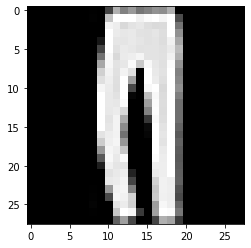

In [104]:
img_clean = input_tensor.cpu().numpy()
plt.imshow(img_clean[0,0],cmap='gray')

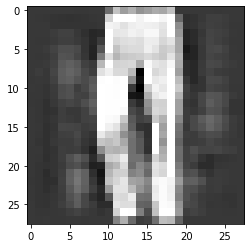

In [105]:
plt.imshow(adversarial_img[0,0],cmap='gray')

In [ ]:
pred_input = model(input_tensor)
pred_prob_input = F.softmax(pred_input, dim=1)
print('prediction of adversarial sample: {} with probability: {}'
      .format(torch.argmax(pred_prob_input),torch.max(pred_prob_input)))

In [ ]:
pred_prob_adv = F.softmax(pred_adv, dim=1)
print('prediction of adversarial sample: {} with probability: {}'.
      format(torch.argmax(pred_prob_adv),torch.max(pred_prob_adv)))


In [ ]:
target_onehot_ar = np.array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
target_onehot = torch.from_numpy(target_onehot_ar)
target_onehot = target_onehot.cuda()

output_ar = np.array([[-5.3372, -5.6212, -4.7658, -3.9166, -2.1613, -3.9361, -6.2410, -2.7965,-2.5990, -0.3694]])
output = torch.from_numpy(output_ar)
output = output.cuda()


In [ ]:
target_onehot

In [ ]:
output

In [ ]:
(target_onehot * output).sum(1)

In [ ]:
real = (target_onehot * output).sum(1)
real

In [ ]:
other = ((1. - target_onehot) * output - target_onehot * 10000.)
other

In [ ]:
other = (other).max(1)[0]
other

In [ ]:
other - real

In [ ]:
torch.clamp(other - real, min=0.)

In [ ]:
# target_onehot:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
# Batch:   0, search step: 0
# output:  tensor([[-5.3372, -5.6212, -4.7658, -3.9166, -2.1613, -3.9361, -6.2410, -2.7965,
#          -2.5990, -0.3694]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
real:  tensor([-5.3372], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([-0.3694], device='cuda:0', grad_fn=<MaxBackward0>)


In [ ]:
real = (target * output).sum(1)
other = ((1. - target) * output - target * 10000.).max(1)[0]
        